In [1]:
import json
from collections import Counter
from dataclasses import dataclass

import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import tifffile
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, Normalize, RandomCrop, Compose
from einops import rearrange
from kmeans_pytorch import kmeans

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import multiplex_imaging_pipeline.utils as utils

In [5]:
scale = .1

In [6]:
metadata = json.load(open('../data/test_registration/HT397B1_v2/registered/metadata.json'))
metadata

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21',
  'HT397B1-S1H3A1U22',
  'HT397B1-S1H3A1U31'],
 'data_type': ['visium', 'codex', 'codex', 'visium', 'codex', 'codex'],
 'slices': ['s0', 's1', 's2', 's3', 's4', 's5']}

In [7]:
fps = sorted(utils.listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered',
                     regex='[0-9].h5ad$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s0.h5ad',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s3.h5ad']

In [8]:
pct_expression = .02
pool = []
for fp in fps:
    a = sc.read_h5ad(fp)
    
    spot_count = (a.X.toarray()>0).sum(0)
    mask = spot_count > pct_expression * a.shape[0]
    a = a[:, mask]

    pool += a.var.index.to_list()
counts = Counter(pool)
channels = sorted([c for c, count in counts.items() if count==len(fps)])
len(channels), channels[:5]

(11630, ['A1BG', 'A2M', 'A4GALT', 'AAAS', 'AACS'])

In [9]:
slide_to_visium = {}
for fp in fps:
    sample = fp.split('/')[-1].replace('.h5ad', '')
    a = sc.read_h5ad(fp)
    label_to_barcode = {i+1:x for i, x in enumerate(a.obs.index)}
    barcode_to_label = {v:k for k, v in label_to_barcode.items()}
    a.uns['label_to_barcode'] = label_to_barcode
    a.uns['barcode_to_label'] = barcode_to_label
#     a.obsm['spatial_scaled'] = (a.obsm['spatial'] * scale).astype(np.int32)
    
    a = a[:, channels]
    sc.pp.log1p(a)
    
    slide_to_visium[sample] = a
slide_to_visium.keys()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


dict_keys(['s0', 's3'])

In [10]:
visium_channels = list(channels)

In [11]:
a = next(iter(slide_to_visium.values()))
a

AnnData object with n_obs × n_vars = 3058 × 11630
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial', 'label_to_barcode', 'barcode_to_label', 'log1p'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original'

In [12]:
fps = sorted(utils.listfiles('/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered',
                     regex='ome.tiff$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s1.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s2.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s4.ome.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1_v2/registered/s5.ome.tiff']

In [13]:
pool = []
for fp in fps:
    channels = utils.get_ome_tiff_channels(fp)
    channels = [utils.R_CHANNEL_MAPPING.get(c, c) for c in channels]
    pool += channels
Counter(pool).most_common()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


[('Bap1', 4),
 ('CD31', 4),
 ('CD45', 4),
 ('CD68', 4),
 ('CD8', 4),
 ('CK19', 4),
 ('COX6c', 4),
 ('DAPI', 4),
 ('ER', 4),
 ('FOXP3', 4),
 ('GATA3', 4),
 ('GLUT1', 4),
 ('HLA-DR', 4),
 ('Her2', 4),
 ('CK14', 4),
 ('Ki67', 4),
 ('MGP', 4),
 ('PLAT/tPA', 4),
 ('PR', 4),
 ('Pan-Cytokeratin', 4),
 ('Podoplanin', 4),
 ('SMA', 4),
 ('Vimentin', 4),
 ('cKit', 4),
 ('CD20', 2),
 ('CD3e', 2),
 ('CD11b', 1),
 ('E-cadherin', 1)]

In [14]:
channels = sorted([c for c, count in Counter(pool).items() if count==len(fps)])
channels

['Bap1',
 'CD31',
 'CD45',
 'CD68',
 'CD8',
 'CK14',
 'CK19',
 'COX6c',
 'DAPI',
 'ER',
 'FOXP3',
 'GATA3',
 'GLUT1',
 'HLA-DR',
 'Her2',
 'Ki67',
 'MGP',
 'PLAT/tPA',
 'PR',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA',
 'Vimentin',
 'cKit']

In [15]:
slide_to_multiplex = {}
for fp in fps:
    sample = fp.split('/')[-1].replace('.ome.tiff', '')
    cs, img = utils.extract_ome_tiff(fp, as_dict=False)
    img = torch.tensor(img)
    thumbnail = TF.resize(img, (int(scale * img.shape[-2]), int(scale * img.shape[-1])))
    thumbnail = thumbnail.to(torch.float32)
    
    cs = [utils.R_CHANNEL_MAPPING[c] for c in cs]
    idxs = [cs.index(c) for c in channels]
    thumbnail = thumbnail[idxs]
    
    slide_to_multiplex[sample] = thumbnail

In [16]:
multiplex_channels = list(channels)

In [17]:
slide_to_data = {k:v for k, v in slide_to_visium.items()}
slide_to_data.update(slide_to_multiplex)
slide_to_data.keys()

dict_keys(['s0', 's3', 's1', 's2', 's4', 's5'])

In [18]:
slide_to_dtype = {s:'visium' for s in slide_to_visium.keys()}
slide_to_dtype.update({s:'multiplex' for s in slide_to_multiplex.keys()})
slide_to_dtype

{'s0': 'visium',
 's3': 'visium',
 's1': 'multiplex',
 's2': 'multiplex',
 's4': 'multiplex',
 's5': 'multiplex'}

In [19]:
samples = sorted(slide_to_data.keys())
samples

['s0', 's1', 's2', 's3', 's4', 's5']

In [20]:
@dataclass
class TransformArgs:
    top_left: tuple
    size: tuple
    vflip: bool
    hflip: bool

def format_expression(tiles, adatas, patch_size):
    # add batch dim if there is none
    if len(tiles.shape) == 2:
        tiles = tiles.unsqueeze(0)
    if isinstance(adatas, anndata.AnnData):
        adatas = [adatas]
    
    exp_imgs = []
    for tile, adata in zip(tiles, adatas):
        tile = rearrange(tile, '(ph h) (pw w) -> h w (ph pw)', ph=patch_size, pw=patch_size)
        x = torch.unique(tile, dim=-1)

        exp = torch.zeros(x.shape[0], x.shape[1], adata.shape[1], dtype=torch.float32)
        l2b = adata.uns['label_to_barcode']
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                labels = x[i, j]
                labels = labels[labels!=0]
                if len(labels):
                    barcodes = [l2b[l.item()] for l in labels]
                    exp[i, j] = torch.tensor(adata[barcodes].X.mean(0))
        exp = rearrange(exp, 'h w c -> c h w')
        exp_imgs.append(exp)
    
    return torch.stack(exp_imgs)

def get_slide_to_labeled(slide_to_adata, crop=True, scale=.1):
    slide_to_labeled = {}
    for s, a in slide_to_adata.items():
        a.obsm['spatial_scaled'] = (a.obsm['spatial'] * scale).astype(np.int32)
        labeled_locations = np.zeros(
            (np.asarray(a.uns['he_rescaled_warped'].shape[:2]) * scale).astype(int), dtype=int)
        for barcode, (c, r) in zip(a.obs.index, a.obsm['spatial_scaled']):
            labeled_locations[r, c] = a.uns['barcode_to_label'][barcode]

        if crop:
            min_c, min_r = a.obsm['spatial_scaled'].min(0)
            max_c, max_r = a.obsm['spatial_scaled'].max(0)
        else:
            min_r, min_c = 0, 0
            max_r, max_c = labeled_locations.shape
        labeled_locations = labeled_locations[min_r:max_r, min_c:max_c]
        slide_to_labeled[s] = torch.tensor(labeled_locations)
    return slide_to_labeled

class TransformVisium(object):
    def __init__(
        self,
        size=(256, 256),
        patch_size=32,
        normalize=None,
    ):
        self.size = size
        self.patch_size = patch_size

        self.normalize = normalize if normalize is not None else nn.Identity()

    def __call__(self, x, adatas, transform_args=None):
        if transform_args is not None:
            x = TF.crop(
                x,
                transform_args.top_left[0],
                transform_args.top_left[1],
                transform_args.size[0],
                transform_args.size[1],
            )
            if transform_args.hflip:
                x = TF.hflip(x)
            if transform_args.vflip:
                x = TF.vflip(x)

        x = format_expression(x, adatas, patch_size=self.patch_size)
        x = self.normalize(x)
        return x
    
class TransformMultiplex(object):
    def __init__(
        self,
        size=(256, 256),
        normalize=None,
    ):
        self.size = size

        self.normalize = normalize if normalize is not None else nn.Identity()

    def __call__(self, x, transform_args=None):
        if transform_args is not None:
            x = TF.crop(
                x,
                transform_args.top_left[0],
                transform_args.top_left[1],
                transform_args.size[0],
                transform_args.size[1],
            )
            if transform_args.hflip:
                x = TF.hflip(x)
            if transform_args.vflip:
                x = TF.vflip(x)
        
        x = self.normalize(x)
        return x
    
    
class SlideDataset(Dataset):
    def __init__(
        self,
        order,
        slide_to_data,
        slide_to_dtype,
        multiplex_transform=None,
        visium_transform=None,
        scale=.1,
        size=(256, 256),
    ):
        self.scale = scale
        self.size = size
        self.slides = order
        self.slide_to_dtype = slide_to_dtype
        self.dtypes = sorted(set(slide_to_dtype.values()))
        
        self.slide_to_multiplex = {
            s:obj for s, obj in slide_to_data.items()
            if slide_to_dtype[s] == 'multiplex'
        }
        
        self.slide_to_visium_adata = {
            s:obj for s, obj in slide_to_data.items()
            if slide_to_dtype[s] == 'visium'
        }
        self.slide_to_visium_labeled = get_slide_to_labeled(
            self.slide_to_visium_adata, crop=False, scale=scale)
        
        multiplex_img = next(iter(self.slide_to_multiplex.values())) # (c h w)
        visium_img = next(iter(self.slide_to_visium_labeled.values())) # (h w)
        assert multiplex_img.shape[-2:] == visium_img.shape[-2:]

        self.multiplex_stacked = torch.stack([
            self.slide_to_multiplex[s]
            for s in self.slides
            if s in self.slide_to_multiplex
        ]) # (b c h w)
        self.visium_stacked = torch.stack([
            self.slide_to_visium_labeled[s]
            for s in self.slides
            if s in self.slide_to_visium_labeled
        ]) # (b h w)
        
        self.dtype_order = torch.tensor([self.dtypes.index(self.slide_to_dtype[s])
                            for s in self.slides])
        
#         index_order, counts = [], {dtype:0 for dtype in self.dtypes}
#         for s in self.slides:
#             dtype = self.slide_to_dtype[s]
#             index_order.append(
#                 [self.dtypes.index(dtype), counts[dtype]]
#             )
#             counts[dtype] += 1
#         self.index_order = torch.tensor(index_order, dtype=torch.long)
        
        self.multiplex_transform = multiplex_transform
        self.visium_transform = visium_transform
    
    def __len__(self):
        return np.iinfo(np.int64).max # make infinite
    
    def __getitem__(self, idx):
        transform_args = TransformArgs(
            top_left = (
                np.random.randint(0, self.multiplex_stacked.shape[-2] - self.size[-2]),
                np.random.randint(0, self.multiplex_stacked.shape[-1] - self.size[-1])
            ),
            size=self.size,
            vflip=np.random.rand() > .5,
            hflip=np.random.rand() > .5,   
        )
        
        multiplex_tiles = self.multiplex_transform(
            self.multiplex_stacked,
            transform_args=transform_args
        )
        visium_tiles = self.visium_transform(
            self.visium_stacked,
            [slide_to_visium[s] for s in self.slides if self.slide_to_dtype[s]=='visium'],
            transform_args=transform_args
        )

        return {
            'stacked_multiplex': multiplex_tiles, # (b c h w)
            'stacked_visium': visium_tiles, # (b c h/ps w/ps)
        }
    
    
# class InferenceSlideDatasetVisium(Dataset):
#     def __init__(self, slide_to_img, size=(256, 256), transform=None, crop=False, scale=.1):
#         """"""
#         self.size = size
#         self.scale = scale
#         self.slides = sorted(slide_to_adata.keys())
#         self.slide_to_adata = slide_to_adata
        
#         self.slide_to_labeled = get_slide_to_labeled(slide_to_adata, crop=crop, scale=scale)
        
#         # tiles are (ph pw c h w)
#         self.slide_to_tiles = {s:self.to_tiles(x.unsqueeze(0)) for s, x in self.slide_to_labeled.items()}
#         self.pw, self.ph = self.slide_to_tiles[self.slides[0]].shape[:2]
        
#         self.n_tiles_per_image = self.pw * self.ph
#         outs = torch.stack(torch.meshgrid(
#             torch.arange(len(self.slides)),
#             torch.arange(self.slide_to_tiles[self.slides[0]].shape[0]),
#             torch.arange(self.slide_to_tiles[self.slides[0]].shape[1])
#         ))
#         self.idx_to_coord = rearrange(
#             outs, 'b n_slides n_rows n_cols -> (n_slides n_rows n_cols) b',
#             n_slides=len(self.slides), n_rows=self.ph, n_cols=self.pw, b=3)


#         self.transform = transform if transform is not None else nn.Identity()
        
#     def to_tiles(self, x):
#         pad_h, pad_w = self.size[-2] - x.shape[-2] % self.size[-2], self.size[-1] - x.shape[-1] % self.size[-1]
#         # left, top, right and bottom
#         x = TF.pad(x, [pad_w // 2, pad_h // 2, pad_w // 2 + pad_w % 2, pad_h // 2 + pad_h % 2])
#         x = x.unfold(-2, self.size[-2], self.size[-2] // 2)
#         x = x.unfold(-2, self.size[-1], self.size[-1] // 2)
#         x = rearrange(x, 'c ph pw h w -> ph pw c h w')
#         return x

#     def image_from_tiles(self, x, to_expression=False, adata=None):
#         pad_h, pad_w = x.shape[-2] // 4, x.shape[-1] // 4
#         x = x[..., pad_h:-pad_h, pad_w:-pad_w]
        
#         if to_expression:
#             ps = self.transform.patch_size
#             new = torch.zeros(x.shape[0], x.shape[1], adata.shape[1], x.shape[-2] // ps, x.shape[-1] // ps,
#                              dtype=torch.float32)
#             for i in range(x.shape[0]):
#                 for j in range(x.shape[1]):
#                     new[i, j] = format_expression(x[i, j, 0], adata, ps)
#             x = new
#         x = rearrange(x, 'ph pw c h w -> c (ph h) (pw w)')
#         return x
        
    
#     def slide_from_tiles(self, x, slide_idx, size=None):
#         """
#         x - (n c h w)
#         """
#         size = size if size is not None else self.size
#         mask = self.idx_to_coord[:, 0]==slide_idx
#         tiles = x[mask]
#         ph, pw = self.idx_to_coord[mask, 1].max() + 1, self.idx_to_coord[mask, 2].max() + 1
        
#         out = torch.zeros(ph, pw, x.shape[1], size[0], size[1])
#         for idx, (_, r, c) in enumerate(self.idx_to_coord[mask]):
#             out[r, c] = tiles[idx]
            
#         return self.image_from_tiles(out)

#     def __len__(self):
#         return self.idx_to_coord.shape[0]

#     def __getitem__(self, idx):
#         slide_idx, row_idx, col_idx = self.idx_to_coord[idx]
#         slide = self.slides[slide_idx]
#         return {
#             'slide_idx': slide_idx,
#             'row_idx': row_idx,
#             'col_idx': col_idx,
#             'img': transform(self.slide_to_tiles[slide][row_idx, col_idx], self.slide_to_adata[slide])
#         }

In [21]:
size = (256, 256)
patch_size = 32

In [22]:
means = np.vstack([a.X.toarray().mean(0) for a in slide_to_visium.values()]).mean(0)
stds = np.vstack([a.X.toarray().std(0) for a in slide_to_visium.values()]).mean(0)
normalize = Normalize(means, stds)
visium_transform = TransformVisium(normalize=normalize, size=size, patch_size=patch_size)

In [23]:
means = torch.cat([x.mean(dim=(-2, -1)).unsqueeze(0) for x in slide_to_multiplex.values()]).mean(0)
stds = torch.cat([x.std(dim=(-2, -1)).unsqueeze(0) for x in slide_to_multiplex.values()]).mean(0)
normalize = Normalize(means, stds)
multiplex_transform = TransformMultiplex(normalize=normalize, size=size)

In [24]:
ds = SlideDataset(
    order=samples,
    slide_to_data=slide_to_data,
    slide_to_dtype=slide_to_dtype,
    multiplex_transform=multiplex_transform,
    visium_transform=visium_transform,
    scale=scale,
    size=size,
)

In [25]:
ds.dtype_order

tensor([1, 0, 0, 1, 0, 0])

In [26]:
ds.dtypes

['multiplex', 'visium']

In [27]:
ds.multiplex_stacked.shape, ds.visium_stacked.shape

(torch.Size([4, 24, 1573, 1551]), torch.Size([2, 1573, 1551]))

In [28]:
ds.slides

['s0', 's1', 's2', 's3', 's4', 's5']

In [29]:
d = ds[0]

In [30]:
d.keys()

dict_keys(['stacked_multiplex', 'stacked_visium'])

In [31]:
d['stacked_multiplex'].shape, d['stacked_visium'].shape

(torch.Size([4, 24, 256, 256]), torch.Size([2, 11630, 8, 8]))

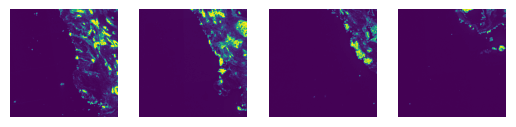

In [32]:
fig, axs = plt.subplots(ncols=len(d['stacked_multiplex']))
for ax, img in zip(axs, d['stacked_multiplex']):
    ax.imshow(img[multiplex_channels.index('Pan-Cytokeratin')])
    ax.axis('off')

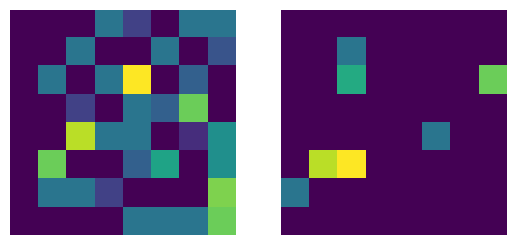

In [33]:
fig, axs = plt.subplots(ncols=len(d['stacked_visium']))
for ax, img in zip(axs, d['stacked_visium']):
    ax.imshow(img[list(a.var.index).index('EPCAM')])
    ax.axis('off')

In [34]:
dl = DataLoader(ds, batch_size=16, num_workers=1)

In [35]:
b = next(iter(dl))
b.keys()

dict_keys(['stacked_multiplex', 'stacked_visium'])

In [36]:
b['stacked_multiplex'].shape, b['stacked_visium'].shape

(torch.Size([16, 4, 24, 256, 256]), torch.Size([16, 2, 11630, 8, 8]))

In [35]:
from vit_pytorch import ViT
from einops.layers.torch import Rearrange

In [110]:
# del(v)
# del(mae)

In [36]:
v = ViT(
    image_size = (256, 256),
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
)

In [37]:
@dataclass
class ShapeArgs:
    patch_size: int
    n_channels: int

In [38]:
dtype_to_shape_args = {
    'multiplex': ShapeArgs(patch_size=32, n_channels=b['stacked_multiplex'].shape[-3]),
    'visium': ShapeArgs(patch_size=1, n_channels=b['stacked_visium'].shape[-3])
}

In [39]:
from vit_pytorch.slide_mae import SlideMAEV4

In [40]:
mae = SlideMAEV4(
    encoder=v,
    decoder_dim=512,
    n_slides=len(samples),
    dtypes=ds.dtypes,
    dtype_to_shape_args=dtype_to_shape_args,
    slide_dtype_order=ds.dtype_order,
    recon_scaler=1.,
    triplet_scaler=0.
)

In [41]:
mae = mae.to('cuda:1')

In [121]:
imgs = [
    b['stacked_multiplex'].to('cuda:1'),
    b['stacked_visium'].to('cuda:1')
]

In [122]:
recon_loss, triplet_loss, overall_loss, pixels = mae(imgs)

In [123]:
recon_loss, triplet_loss, overall_loss

(tensor(2.0394, device='cuda:1', grad_fn=<MseLossBackward0>),
 0,
 tensor(2.0394, device='cuda:1', grad_fn=<MseLossBackward0>))

In [42]:
def plot_recons(pixels, n_cols=6, do_rearrange=True):
    fig, axs = plt.subplots(nrows=2, ncols=n_cols)
    for i in range(len(pixels)):
        dtype = ds.dtypes[i]
        pred_pixels = pixels[i]
        args = dtype_to_shape_args[dtype]
        if do_rearrange:
            pred_pixels = rearrange(pred_pixels, 'b (ph pw) (h w c) -> b c (h ph) (w pw)',
                                    ph=8, pw=8, c=args.n_channels, h=args.patch_size, w=args.patch_size)
        

        if dtype == 'multiplex':
            x = pred_pixels[:n_cols, channels.index('Pan-Cytokeratin')].cpu().detach()
            for col in range(n_cols):
                axs[0, col].imshow(x[col])
                axs[0, col].axis('off')

        if dtype == 'visium':
            c_idx = list(next(iter(ds.slide_to_visium_adata.values())).var.index).index('EPCAM')
            x = pred_pixels[:n_cols, c_idx].cpu().detach()
            for col in range(n_cols):
                axs[1, col].imshow(x[col])
                axs[1, col].axis('off')

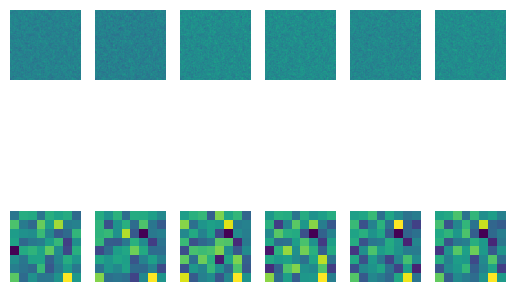

In [104]:
plot_recons(pixels)

In [43]:
iters = 100000
lr = 1e-4
opt = torch.optim.Adam(mae.parameters(), lr=lr)

In [44]:
!mkdir -p ../data/mae_v8

In [45]:
dl = DataLoader(ds, batch_size=16, num_workers=10)

torch.Size([64, 64, 24576])
0 tensor(2.2423, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(2.2423, device='cuda:1', grad_fn=<MseLossBackward0>)


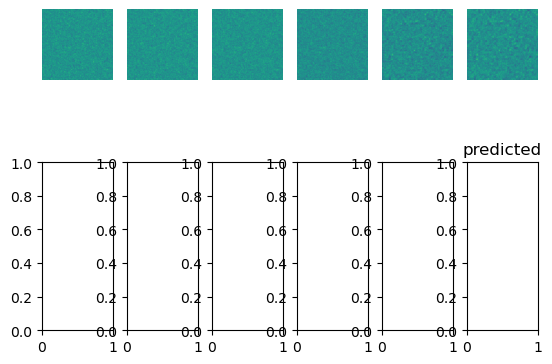

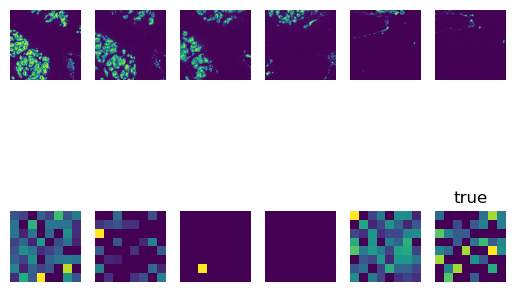

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
10 tensor(1.7567, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.7567, device='cuda:1', grad_fn=<MseLossBackward0>)


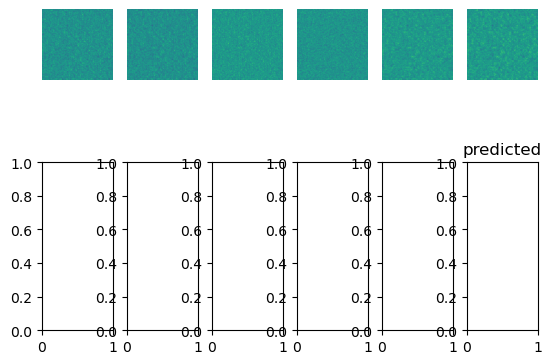

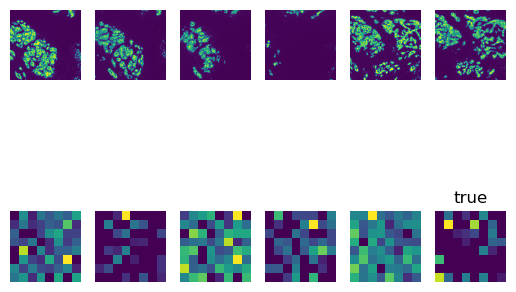

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
20 tensor(1.5186, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.5186, device='cuda:1', grad_fn=<MseLossBackward0>)


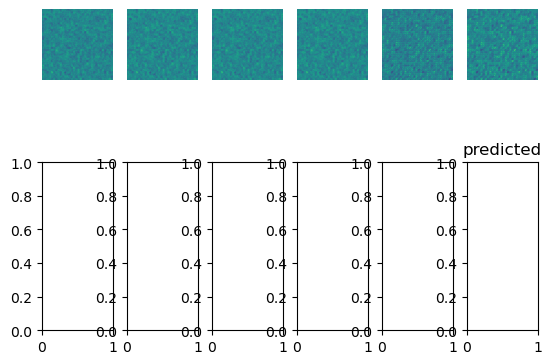

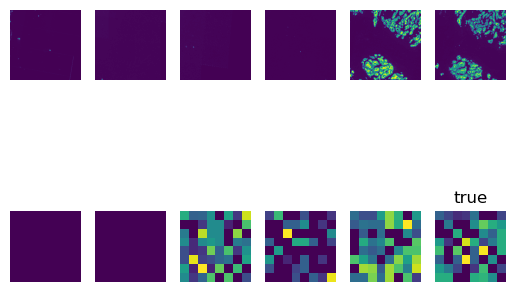

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
30 tensor(1.6839, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.6839, device='cuda:1', grad_fn=<MseLossBackward0>)


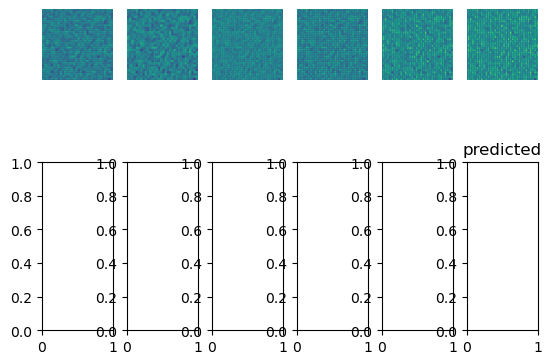

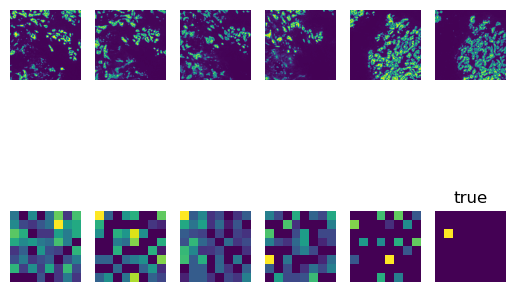

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
40 tensor(1.3449, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.3449, device='cuda:1', grad_fn=<MseLossBackward0>)


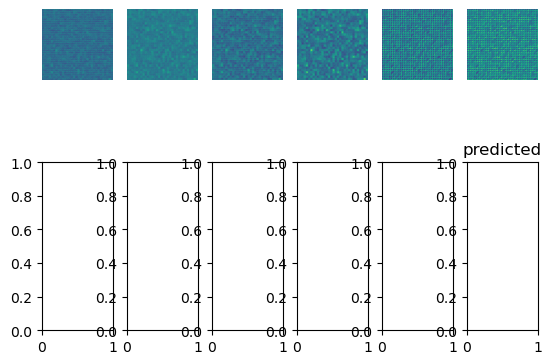

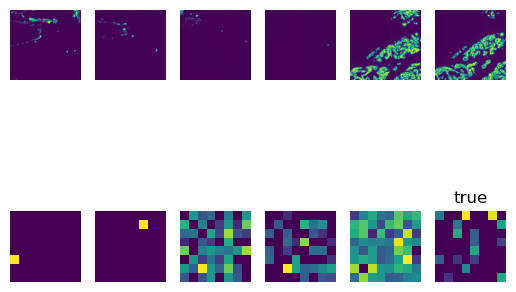

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
50 tensor(1.1196, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.1196, device='cuda:1', grad_fn=<MseLossBackward0>)


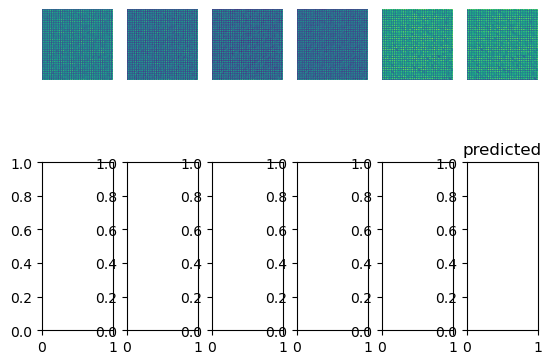

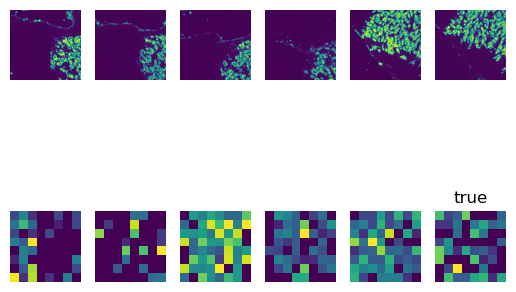

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
60 tensor(1.6307, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.6307, device='cuda:1', grad_fn=<MseLossBackward0>)


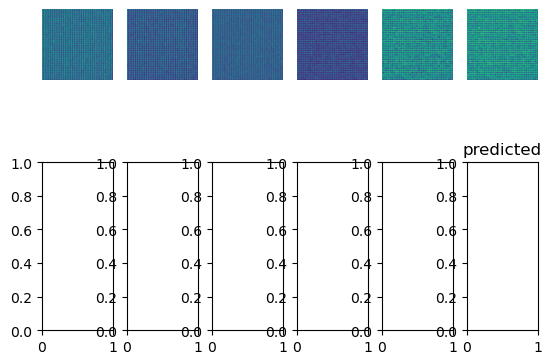

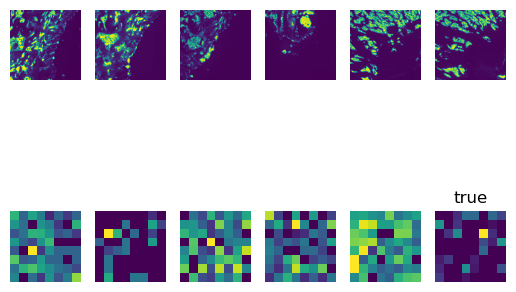

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
70 tensor(1.3256, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.3256, device='cuda:1', grad_fn=<MseLossBackward0>)


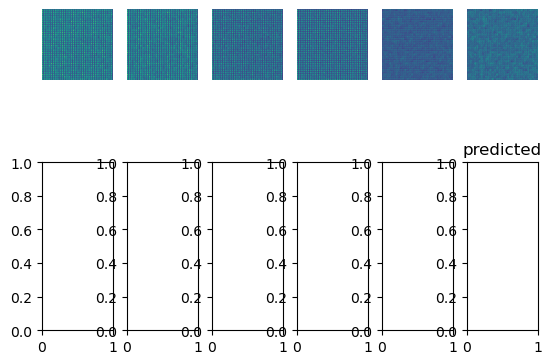

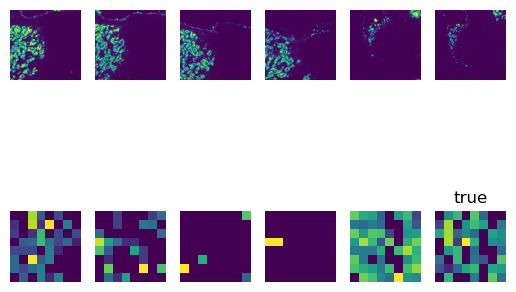

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
80 tensor(1.1032, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.1032, device='cuda:1', grad_fn=<MseLossBackward0>)


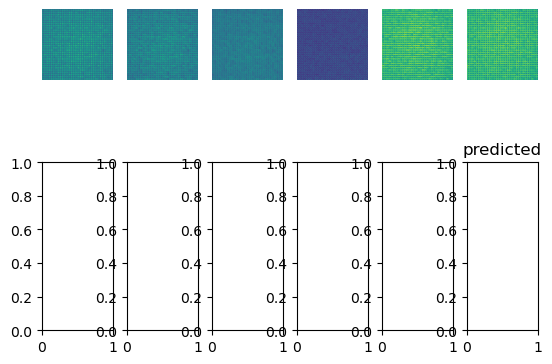

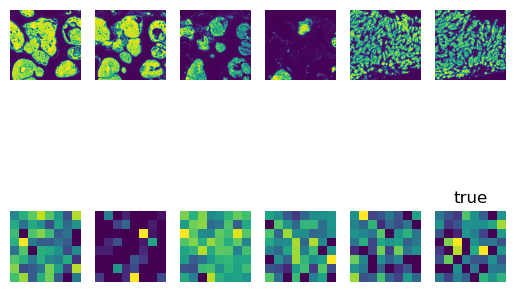

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
90 tensor(1.0862, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.0862, device='cuda:1', grad_fn=<MseLossBackward0>)


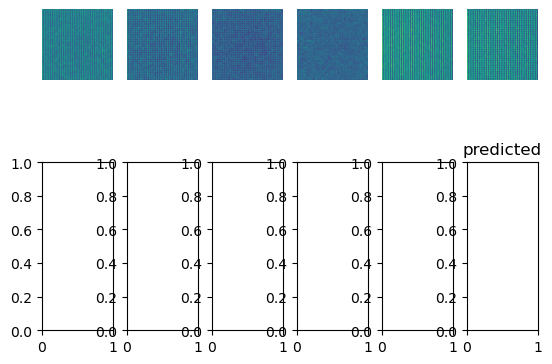

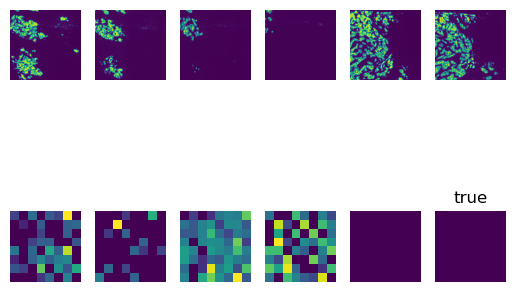

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
100 tensor(1.1190, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.1190, device='cuda:1', grad_fn=<MseLossBackward0>)


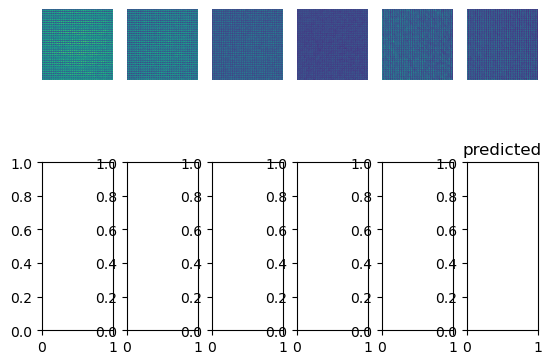

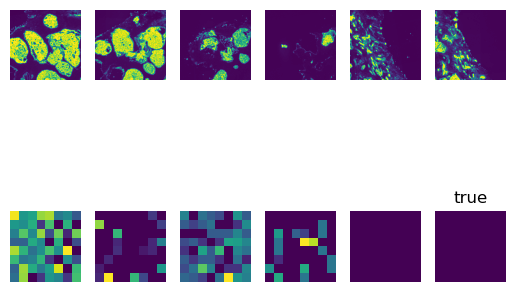

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
110 tensor(1.1565, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.1565, device='cuda:1', grad_fn=<MseLossBackward0>)


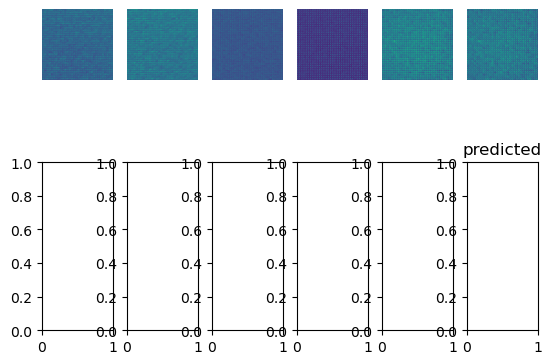

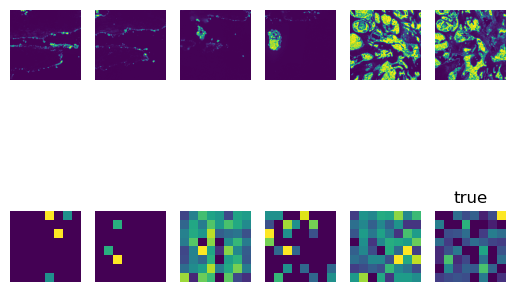

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
120 tensor(1.2006, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.2006, device='cuda:1', grad_fn=<MseLossBackward0>)


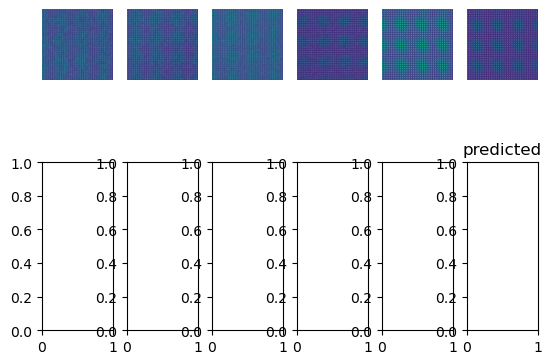

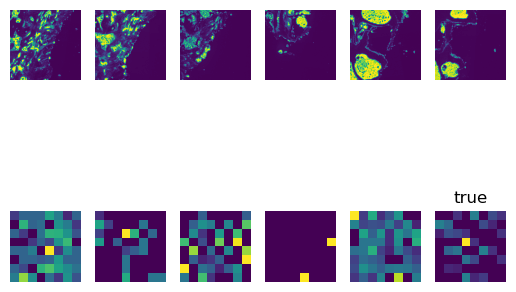

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
130 tensor(0.8627, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(0.8627, device='cuda:1', grad_fn=<MseLossBackward0>)


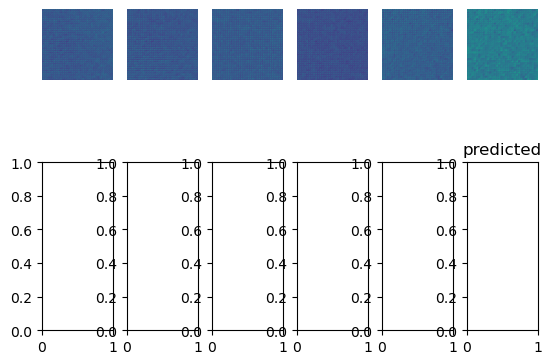

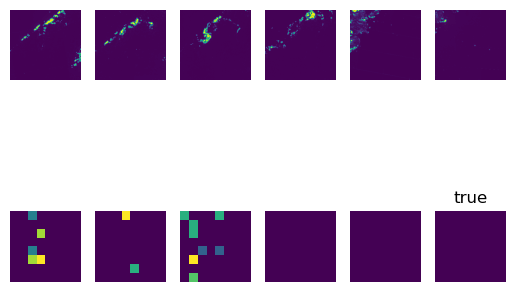

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
140 tensor(1.1934, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.1934, device='cuda:1', grad_fn=<MseLossBackward0>)


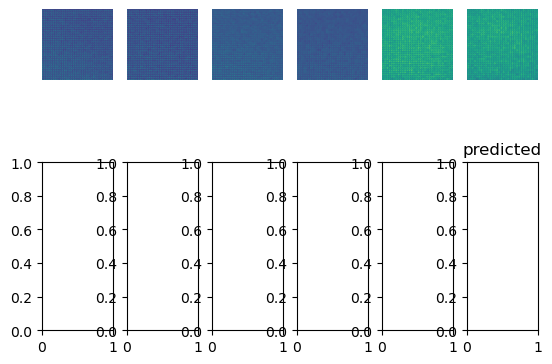

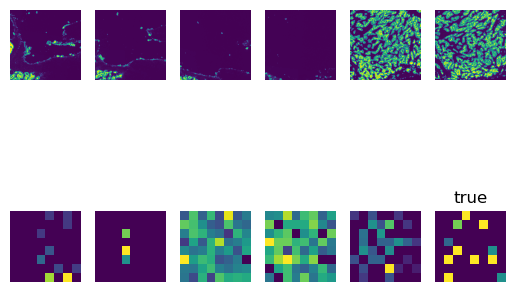

torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
torch.Size([64, 64, 24576])
150 tensor(1.1848, device='cuda:1', grad_fn=<MseLossBackward0>) 0 tensor(1.1848, device='cuda:1', grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

In [46]:
for i, b in enumerate(dl):
    opt.zero_grad()
    
    imgs = [
        b['stacked_multiplex'].to('cuda:1'),
        b['stacked_visium'].to('cuda:1')
    ]
    recon_loss, triplet_loss, overall_loss, pixels = mae(imgs)
    overall_loss.backward()
    opt.step()
    print(pixels.shape)
    
    if i % 10 == 0:
        with torch.no_grad():
            print(i, recon_loss, triplet_loss, overall_loss)
            plot_recons([pixels])
            plt.title('predicted')
            plt.show()

            patches = []
            stacked_imgs, *_ = mae.prepare_inputs(imgs)
            plot_recons(stacked_imgs, do_rearrange=False)
            plt.title('true')
            plt.show()
        
    if i % 5000 == 0:
        torch.save(mae.state_dict(), f'../data/mae_v8/{i}iter.pt')
        
    if i == iters:
        break

In [61]:
# torch.save(v.state_dict(), f'../data/mae_v3/1500iter.pt')

In [28]:
size = (256, 256)

normalize = Normalize(means, stds)
transform = InferenceTransformVisium(size=(256, 256), patch_size=32, normalize=normalize)
inference_ds = InferenceSlideDatasetVisium(slide_to_adata, size=(256, 256), transform=transform, crop=False)

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [29]:
inference_dl = DataLoader(inference_ds, batch_size=32, shuffle=False)

In [30]:
x = inference_ds.image_from_tiles(inference_ds.slide_to_tiles[inference_ds.slides[0]],
                                  to_expression=True, adata=inference_ds.slide_to_adata['s0'])
x.shape

torch.Size([11630, 52, 52])

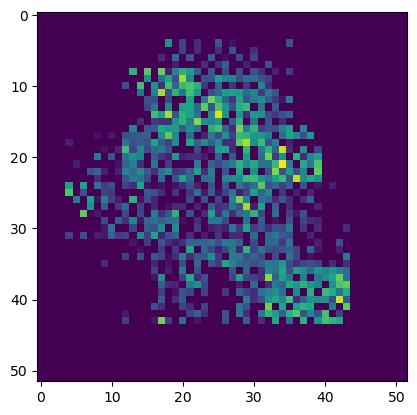

In [31]:
plt.imshow(x[channels.index('EPCAM')])

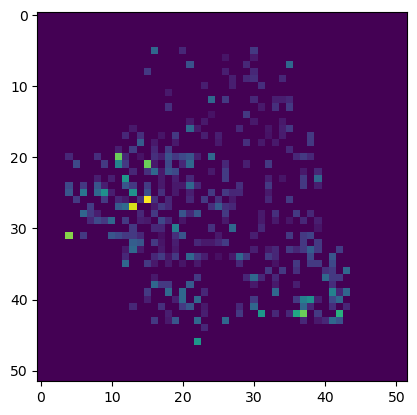

In [32]:
plt.imshow(x[channels.index('IL7R')])

In [33]:
d = inference_ds[0]
d.keys()

dict_keys(['slide_idx', 'row_idx', 'col_idx', 'img'])

In [34]:
d['img'].shape

torch.Size([11630, 8, 8])

In [303]:
v = ViT(
    image_size = 8,
    patch_size = 1,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    channels=len(channels),
)

In [304]:
mae = SlideMAEV2(
    encoder = v,
    n_slides = len(slide_to_adata),
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [305]:
mae.load_state_dict(torch.load('../data/mae_v5/6000iter.pt'))

<All keys matched successfully>

In [306]:
mae.eval()

SlideMAEV2(
  (encoder): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=1, p2=1)
      (1): LayerNorm((11630,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=11630, out_features=1024, bias=True)
      (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_qkv): Linear(in_features=1024, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=1024, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
          (1):

In [197]:
all_encoded_tokens = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, v.pos_embedding.shape[-1])
all_decoded_tokens = torch.zeros(len(inference_ds), size[0] // 32, size[1] // 32, mae.decoder_dim)
all_pred_patches = torch.zeros(len(inference_ds), len(channels), size[0] // 32, size[1] // 32)
bs = inference_dl.batch_size
with torch.no_grad():
    for i, b in enumerate(inference_dl):
        x, slide_idx = b['img'], b['slide_idx']
        if v.pos_embedding.is_cuda:
            x, slide_idx = x.to(v.pos_embedding.device), slide_idx.to(v.pos_embedding.device)
        
        encoded_tokens = mae.encode(x, slide_idx)
        decoded_tokens = mae.decode(encoded_tokens)
        pred_pixel_values = mae.to_pixels(decoded_tokens[:, 1:])

        encoded_tokens = rearrange(encoded_tokens[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        decoded_tokens = rearrange(decoded_tokens[:, 1:], 'b (h w) d -> b h w d',
                                  h=size[0] // 32, w=size[1] // 32)
        pred_patches = rearrange(
            pred_pixel_values, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=size[0] // 32, w=size[0] // 32, p1=1, p2=1, c=len(channels))
        
        all_encoded_tokens[i * bs:(i + 1) * bs] = encoded_tokens.cpu().detach()
        all_decoded_tokens[i * bs:(i + 1) * bs] = decoded_tokens.cpu().detach()
        all_pred_patches[i * bs:(i + 1) * bs] = pred_patches.cpu().detach()

In [198]:
all_encoded_tokens.shape, all_decoded_tokens.shape, all_pred_patches.shape

(torch.Size([338, 8, 8, 1024]),
 torch.Size([338, 8, 8, 512]),
 torch.Size([338, 11630, 8, 8]))

In [81]:
x = inference_ds.slide_from_tiles(all_pred_patches, 0, size=all_pred_patches.shape[-2:])
x.shape

torch.Size([11630, 52, 52])

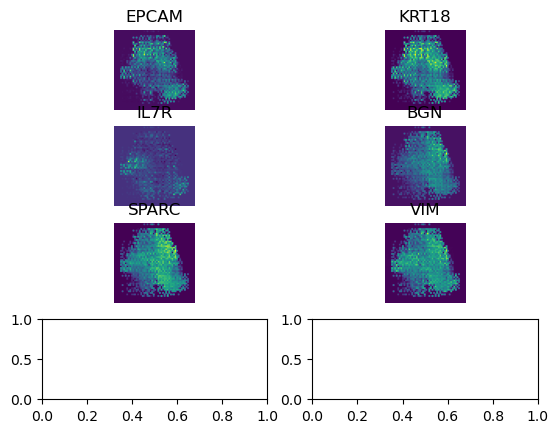

In [38]:
genes = [
    'EPCAM', 'KRT18',
    'IL7R',
    'BGN', 'SPARC', 'VIM',
]
n_cols = 2
n_rows = len(genes) // n_cols + 1
rc = [(i, j) for i in range(n_rows) for j in range(n_cols)]

fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows)
rc = [(i, j) for i in range(n_rows) for j in range(n_cols)]
for (row_idx, col_idx), c in zip(rc, genes):
    ax = axs[row_idx, col_idx]
    ax.imshow(x[channels.index(c)])
    ax.axis('off')
    ax.set_title(c)

In [274]:
all_encoded_tokens.shape

torch.Size([338, 8, 8, 1024])

In [ ]:
# testing regressing out tokens

In [273]:
import statsmodels.api as sm

In [307]:
# data = sm.datasets.scotland.load()
# data.exog = sm.add_constant(data.exog)

# gamma_model = sm.GLM(data.endog, data.exog, family=sm.families.Gamma())
# gamma_results = gamma_model.fit()



In [308]:
# gamma_results.summary()

In [319]:
from sklearn.linear_model import LinearRegression

In [320]:
x = all_encoded_tokens.clone()
x = rearrange(x, 'n h w d -> (n h w) d')
x = x.numpy()
x.shape

(21632, 1024)

In [321]:
regressors = torch.zeros(all_encoded_tokens.shape[:-1], dtype=torch.long).unsqueeze(-1)
idx_to_var = [(r, c) for r in range(regressors.shape[1]) for c in range(regressors.shape[2])]
var_to_idx = {v:i for i, v in enumerate(idx_to_var)}
for i, (slide_idx, row_idx, col_idx) in enumerate(inference_ds.idx_to_coord):
    for r in range(regressors.shape[1]):
        for c in range(regressors.shape[2]):
            regressors[i, r, c] = var_to_idx[(r, c)]
target = rearrange(regressors, 'n h w d -> (n h w) d').squeeze()
target = torch.nn.functional.one_hot(target).numpy()
# target = target.numpy()
target.shape

(21632, 64)

In [322]:
# idxs = np.random.choice(np.arange(target.shape[0]), size=1000, replace=False)
# x = x[idxs]
# target = target[idxs]
# x.shape, target.shape

In [327]:
# lm = LinearRegression()
# lm.fit(x, target)
# residuals = lm.predict(x) - target
# residuals.shape

(21632, 64)

In [328]:
lm = LinearRegression()
lm.fit(target, x)
residuals = lm.predict(target) - x
residuals.shape

(21632, 1024)

In [331]:
x = torch.tensor(residuals)
x.shape

torch.Size([21632, 1024])

In [332]:
clusterer = KMeans(n_clusters=20)
cluster_ids = clusterer.fit_transform(x.numpy())
cluster_ids = torch.tensor(cluster_ids.argmin(1))
cluster_ids.shape

torch.Size([21632])

In [334]:
cluster_imgs = rearrange(cluster_ids, '(n h w) -> n 1 h w',
                        n=all_encoded_tokens.shape[0], h=all_encoded_tokens.shape[1], w=all_encoded_tokens.shape[2])
labeled_img = inference_ds.slide_from_tiles(
    cluster_imgs, 0, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long)

stacked_labeled = []
for i in range(len(slide_to_adata)):
    stacked_labeled.append(inference_ds.slide_from_tiles(
        cluster_imgs, i, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long))
stacked_labeled = torch.stack(stacked_labeled)
stacked_labeled.shape

torch.Size([2, 52, 52])

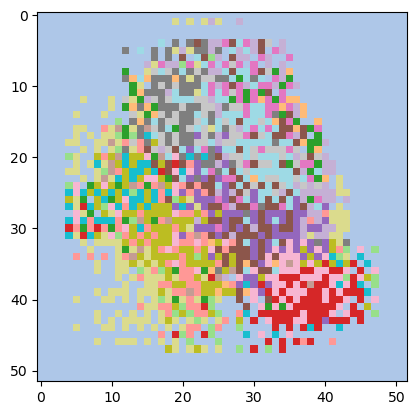

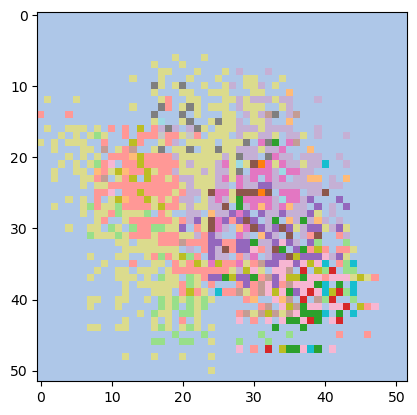

In [335]:
cmap = sns.color_palette('tab20')
for i, labeled in enumerate(stacked_labeled):
    plt.imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    plt.show()

In [336]:
cmap

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [337]:
cluster = 20

In [ ]:
to_labeled = torch.zeros(338, 8, 8, 1, dtype=torch.long)
idx_to_str = {}
idx = 0
for i, (slide_idx, row_idx, col_idx) in enumerate(inference_ds.idx_to_coord):
    for r in range(labeled.shape[1]):
        for c in range(labeled.shape[2]):
            idx_to_str[idx] = f'slide{slide_idx}_row{row_idx}_col{col_idx}_{r}_{c}'
            labeled[i, r, c] = idx
            idx += 1
labeled.shape

In [339]:
z = inference_ds.slide_to_tiles['s0']
z.shape

torch.Size([13, 13, 1, 256, 256])

In [340]:
z = inference_ds.slide_to_labeled['s0']
z.shape

torch.Size([1573, 1551])

In [353]:
a = slide_to_adata['s3']
a

AnnData object with n_obs × n_vars = 2340 × 11630
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial', 'label_to_barcode', 'barcode_to_label', 'log1p'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original', 'spatial_scaled'

In [354]:
sc.pp.calculate_qc_metrics(a, inplace=True)

In [355]:
a

AnnData object with n_obs × n_vars = 2340 × 11630
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial', 'label_to_barcode', 'barcode_to_label', 'log1p'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original', 'spatial_scaled'

In [356]:
a.obs

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACAGAGCGACTCCT-1,1,14,94,3109,8.042378,2750.457275,7.919886,4.398444,7.762162,13.607793,27.483890
AAACAGCTTTCAGAAG-1,1,43,9,51,3.951244,36.161430,3.615271,98.083191,100.000000,100.000000,100.000000
AAACAGTGTTCCTGGG-1,1,73,43,92,4.532599,67.706406,4.229843,57.002354,100.000079,100.000079,100.000079
AAACCGGGTAGGTACC-1,1,42,28,209,5.347108,152.675842,5.034845,27.814142,50.514144,95.914089,100.000090
AAACCGTTCGTCCAGG-1,1,52,42,3903,8.269757,3733.689453,8.225420,3.898657,6.813712,11.796795,23.933187
...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,5105,8.538172,5116.640137,8.540449,3.230641,5.632273,9.828916,20.123850
TTGTTGTGTGTCAAGA-1,1,31,77,3268,8.092239,2944.963867,7.988192,4.848655,8.222813,13.916974,27.457143
TTGTTTCACATCCAGG-1,1,58,42,4894,8.495970,5024.913086,8.522363,3.276309,5.821087,10.211842,20.968824
TTGTTTCATTAGTCTA-1,1,60,30,423,6.049733,323.153961,5.781219,19.491735,30.718357,52.167811,100.000057


/tmp/ipykernel_3078691/816232611.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a.obs['n_genes_by_counts'])


<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Density'>

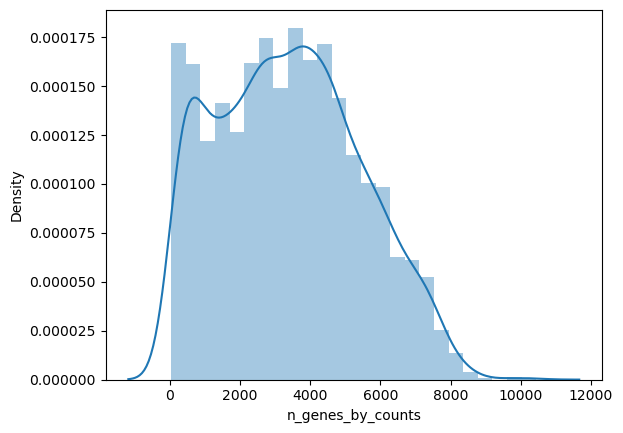

In [351]:
sns.distplot(a.obs['n_genes_by_counts'])

/tmp/ipykernel_3078691/816232611.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a.obs['n_genes_by_counts'])


<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Density'>

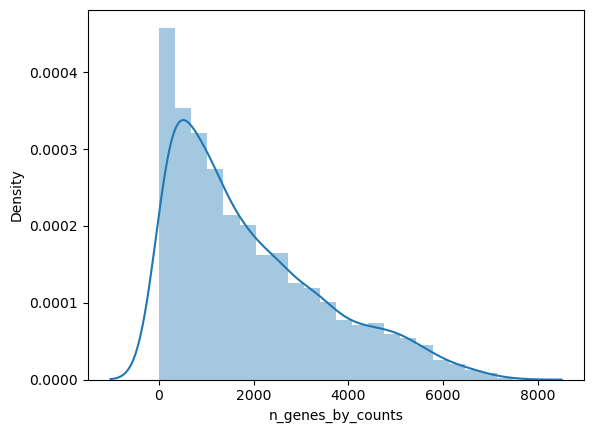

In [357]:
sns.distplot(a.obs['n_genes_by_counts'])

In [266]:
x = all_encoded_tokens.clone()
x = rearrange(x, 'n h w d -> (n h w) d')
# x /= x.std(0)

In [267]:
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=20)
cluster_ids = clusterer.fit_transform(x.numpy())
cluster_ids = torch.tensor(cluster_ids.argmin(1))
cluster_ids.shape

torch.Size([21632])

In [268]:
# num_clusters = 20
# cluster_ids, cluster_centers = kmeans(
#     X=x, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda:1'), tol=1.,
# )
# cluster_ids = cluster_ids.cpu().detach()

In [269]:
cluster_imgs = rearrange(cluster_ids, '(n h w) -> n 1 h w',
                        n=all_encoded_tokens.shape[0], h=all_encoded_tokens.shape[1], w=all_encoded_tokens.shape[2])
labeled_img = inference_ds.slide_from_tiles(
    cluster_imgs, 0, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long)
labeled_img.shape

torch.Size([52, 52])

In [270]:
def display_labeled_as_rgb(labeled, cmap=None):
    if isinstance(labeled, torch.Tensor):
        labeled = labeled.numpy()
    cmap = sns.color_palette() if cmap is None else cmap
    labels = sorted(np.unique(labeled))
    if len(cmap) < len(labels):
        raise RuntimeError('cmap is too small')
    new = np.zeros((labeled.shape[0], labeled.shape[1], 3))
    for l in labels:
        c = cmap[l]
        new[labeled==l] = c
    return new

In [271]:
stacked_labeled = []
for i in range(len(slide_to_adata)):
    stacked_labeled.append(inference_ds.slide_from_tiles(
        cluster_imgs, i, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long))
stacked_labeled = torch.stack(stacked_labeled)
stacked_labeled.shape

torch.Size([2, 52, 52])

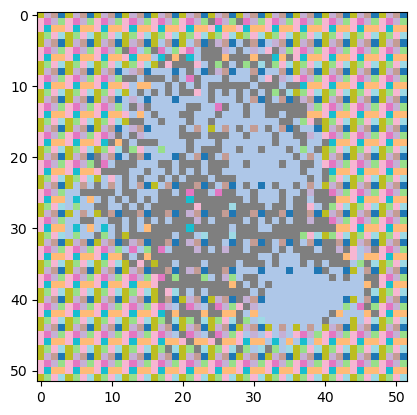

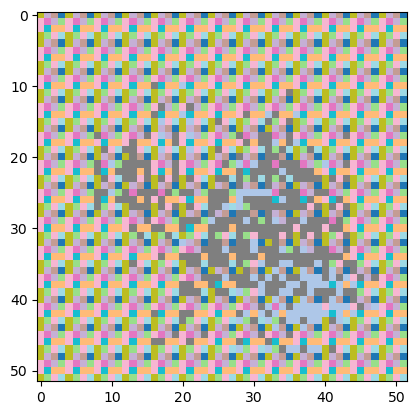

In [272]:
cmap = sns.color_palette('tab20')
for i, labeled in enumerate(stacked_labeled):
    plt.imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    plt.show()

In [202]:
size = (256, 256)

In [203]:
shape = inference_ds.slide_to_labeled['s0'].shape
shape

torch.Size([1573, 1551])

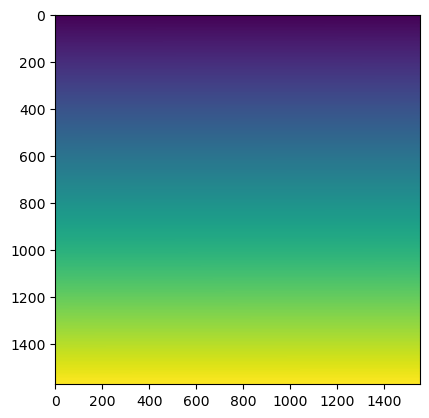

In [204]:
labeled = torch.arange(shape[0] * shape[1])
labeled = rearrange(labeled, '(h w) -> h w', h=shape[0], w=shape[1])
plt.imshow(labeled)

In [205]:
tiles = inference_ds.to_tiles(labeled.unsqueeze(0))
tiles.shape

torch.Size([13, 13, 1, 256, 256])

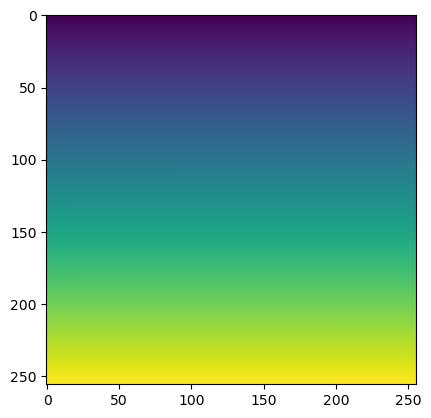

In [207]:
plt.imshow(tiles[6, 8, 0])

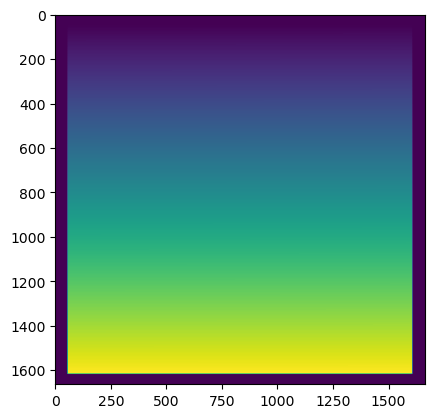

In [211]:
out = inference_ds.image_from_tiles(tiles).squeeze()
plt.imshow(out)

In [212]:
338, 8, 8, 1024

torch.Size([13, 13, 1, 256, 256])

In [233]:
labeled = torch.zeros(338, 8, 8, 1, dtype=torch.long)
idx_to_str = {}
idx = 0
for i, (slide_idx, row_idx, col_idx) in enumerate(inference_ds.idx_to_coord):
    for r in range(labeled.shape[1]):
        for c in range(labeled.shape[2]):
            idx_to_str[idx] = f'slide{slide_idx}_row{row_idx}_col{col_idx}_{r}_{c}'
            labeled[i, r, c] = idx
            idx += 1
labeled.shape

torch.Size([338, 8, 8, 1])

In [234]:
idx_to_str[labeled[10, 1, 1, 0].item()]

'slide0_row0_col10_1_1'

In [235]:
pre_cluster_labeled = rearrange(labeled, 'n h w d -> (n h w) d')
pre_cluster_labeled.shape

torch.Size([21632, 1])

In [236]:
post_cluster_labeled = pre_cluster_labeled.squeeze()
post_cluster_labeled.shape

torch.Size([21632])

In [237]:
post_cluster_image = rearrange(post_cluster_labeled, '(n h w) -> n 1 h w',
                        n=all_encoded_tokens.shape[0], h=all_encoded_tokens.shape[1], w=all_encoded_tokens.shape[2])
post_cluster_image.shape

torch.Size([338, 1, 8, 8])

In [238]:
slide_from_tiles_img = inference_ds.slide_from_tiles(
    post_cluster_image, 0, size=(post_cluster_image.shape[-2], post_cluster_image.shape[-1])).squeeze().to(torch.long)
slide_from_tiles_img.shape

torch.Size([52, 52])

In [242]:
idx = slide_from_tiles_img[0, 0].item()
idx_to_str[idx]

'slide0_row0_col0_2_2'

In [246]:
idx = slide_from_tiles_img[4, 0].item()
idx_to_str[idx]

'slide0_row1_col0_2_2'

In [247]:
idx = slide_from_tiles_img[33, 44].item()
idx_to_str[idx]

'slide0_row8_col11_3_2'

In [248]:
8 * 4

32

In [122]:
tiles = inference_ds.slide_to_tiles['s0']
tiles.shape

torch.Size([13, 13, 1, 256, 256])

In [133]:
mask = torch.zeros(len(inference_ds.idx_to_coord), 8, 8, dtype=torch.bool)
for i, (slide_idx, row_idx, col_idx) in enumerate(inference_ds.idx_to_coord):
    slide = inference_ds.slides[slide_idx]
    labeled_tile = inference_ds.slide_to_tiles[slide][row_idx, col_idx, 0]
    labeled_tile = rearrange(labeled_tile, '(ph h) (pw w) -> h w (ph pw)', ph=32, pw=32)
    mask[i] = labeled_tile.sum(dim=-1) > 0
mask.shape

torch.Size([338, 8, 8])

In [139]:
mask[60]

tensor([[ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True]])

In [127]:
# slide_to_hulls = {}
# for slide in inference_ds.slides:
#     x = inference_ds.image_from_tiles(inference_ds.slide_to_tiles[slide]).squeeze()
#     z = 52 / x.shape[0]
#     pts = (x!=0).argwhere().to(torch.float32)
#     pts *= z
#     pts = pts.to(torch.long)
    
#     mask = np.zeros((52, 52))
#     for r, c in pts:
#         mask[r, c] = True
#     slide_to_hulls[slide] = mask
# #     hull = convex_hull_image(mask)
# #     slide_to_hulls[slide] = hull
# for slide, hull in slide_to_hulls.items():
#     plt.imshow(hull)
#     plt.title(slide)
#     plt.show()

In [195]:
zzz = mask.unsqueeze(1)
zzz_img = inference_ds.slide_from_tiles(
    zzz, 0, size=(zzz.shape[-2], zzz.shape[-1])).squeeze().to(torch.long)
zzz_img.shape

torch.Size([52, 52])

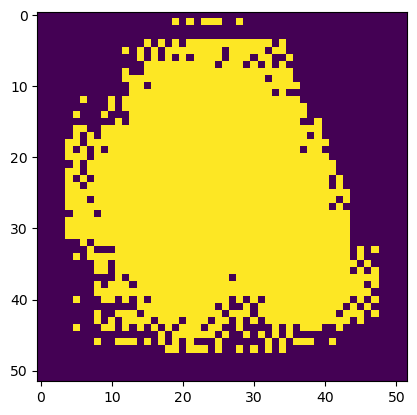

In [196]:
plt.imshow(zzz_img)

In [160]:
x = all_encoded_tokens.clone()
x[~mask] = torch.zeros(x.shape[-1])
x = rearrange(x, 'n h w d -> (n h w) d')
x /= x.std(0)

In [161]:
(x.sum(-1)==0).sum()

tensor(12181)

In [171]:
x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [183]:
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=10)
cluster_ids = clusterer.fit_transform(x.numpy())
cluster_ids.shape

(21632, 10)

In [184]:
cluster_ids = cluster_ids.argmin(1)
np.unique(cluster_ids, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([20215,   160,   160,   150,   170,   152,   149,   150,   175,
          151]))

In [185]:
cluster_ids = torch.tensor(cluster_ids)

In [186]:
# num_clusters = 5
# cluster_ids, cluster_centers = kmeans(
#     X=x, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda:1'), tol=1.,
# )

In [187]:
# cluster_ids, cluster_centers = cluster_ids.cpu().detach(), cluster_centers.cpu().detach()

In [188]:
# cluster_ids.shape, cluster_centers.shape

In [189]:
cluster_imgs = rearrange(cluster_ids, '(n h w) -> n 1 h w',
                        n=all_encoded_tokens.shape[0], h=all_encoded_tokens.shape[1], w=all_encoded_tokens.shape[2])
cluster_imgs.shape

torch.Size([338, 1, 8, 8])

In [190]:
labeled_img = inference_ds.slide_from_tiles(
    cluster_imgs, 0, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long)
labeled_img.shape

torch.Size([52, 52])

In [191]:
labeled_img

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [192]:
def display_labeled_as_rgb(labeled, cmap=None):
    if isinstance(labeled, torch.Tensor):
        labeled = labeled.numpy()
    cmap = sns.color_palette() if cmap is None else cmap
    labels = sorted(np.unique(labeled))
    if len(cmap) < len(labels):
        raise RuntimeError('cmap is too small')
    new = np.zeros((labeled.shape[0], labeled.shape[1], 3))
    for l in labels:
        c = cmap[l]
        new[labeled==l] = c
    return new

In [193]:
import seaborn as sns

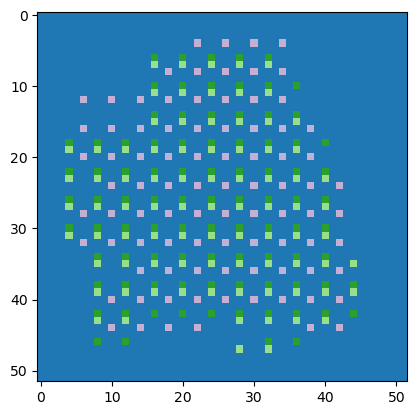

In [194]:
# cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
cmap = sns.color_palette('tab20')
plt.imshow(display_labeled_as_rgb(labeled_img, cmap=cmap))

In [47]:
stacked_labeled = []
for i in range(len(slide_to_adata)):
    stacked_labeled.append(inference_ds.slide_from_tiles(
        cluster_imgs, i, size=(cluster_imgs.shape[-2], cluster_imgs.shape[-1])).squeeze().to(torch.long))
stacked_labeled = torch.stack(stacked_labeled)
stacked_labeled.shape

torch.Size([2, 52, 52])

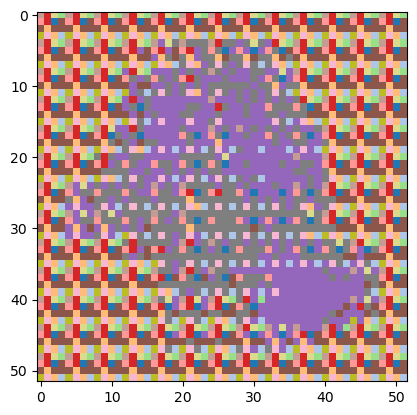

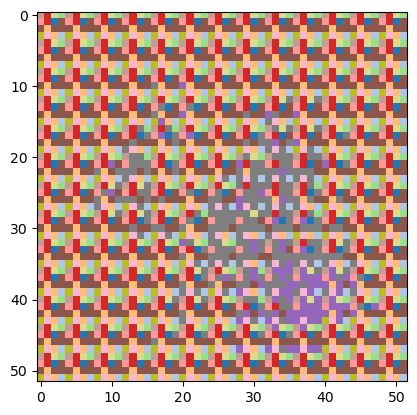

In [48]:
cmap = sns.color_palette('tab20')
for i, labeled in enumerate(stacked_labeled):
    plt.imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    plt.show()

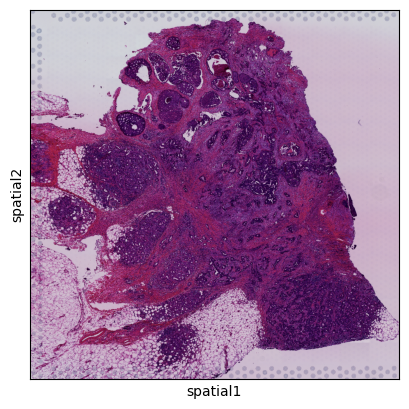

In [339]:
sc.pl.spatial(slide_to_adata['s0'])

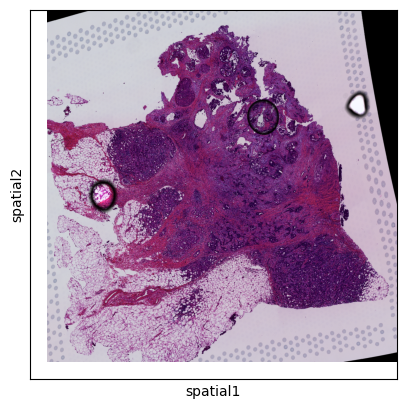

In [338]:
sc.pl.spatial(slide_to_adata['s3'])

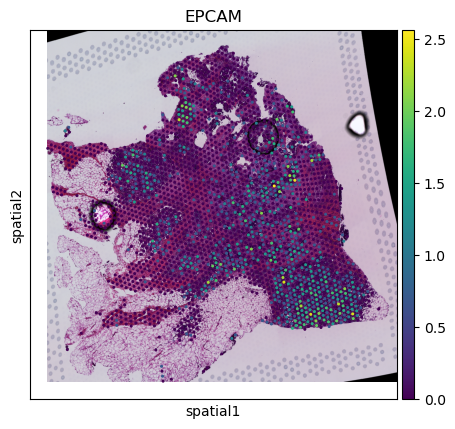

In [340]:
sc.pl.spatial(slide_to_adata['s3'], color='EPCAM')